## AudioCLIP Instrument Recognition & Retrieval Demo

Based on the original [AudioCLIP repository by Andrey Guzhov](https://github.com/AndreyGuzhov)

This notebook demonstrates how to use a **pretrained AudioCLIP model** to recognize and retrieve musical instruments from the **IRMAS dataset**.  
It focuses on **zero-shot prediction** — identifying instruments using natural-language prompts such as *“the sound of a piano”* without any additional training.

Below you will find an overview of the notebook’s structure.

---

## Notebook Outline

### Setup & Preparation
1. [Downloading Binary Assets](#downloading-binary-assets)  
 Download pretrained model weights and vocabulary if missing.  
2. [Imports & Constants](#imports--constants)  
 Import required libraries and define constants such as sample rate and paths.  
3. [Paths, Assets, and Auto-Downloads](#paths-assets-and-auto-downloads)  
 Configure data directories and automatically fetch any missing files.

### Dataset Construction
4. [Canonical Prompt Phrasing for Instruments](#canonical-prompt-phrasing-for-instruments)  
 Define consistent natural-language descriptions for each instrument.  
5. [Build the IRMAS DataFrame (scan WAVs + read labels)](#build-the-irmas-dataframe-scan-wavs--read-labels)  
 Load all `.wav` and `.txt` files, parse labels, and construct a tidy dataset.  
6. [Create an Evaluation Subset with Single Labels](#create-an-evaluation-subset-with-single-labels)  
 Filter the dataset to only include clips with a single, unambiguous instrument label.

### Model Setup & Embedding Generation
7. [Initialize AudioCLIP for Inference](#initialize-audioclip-for-inference)  
 Load the pretrained AudioCLIP model in evaluation mode and prepare audio transforms.  
8. [Audio → Segments → Embeddings (batching + optional window pooling)](#audio--segments--embeddings-batching--optional-window-pooling)  
 Convert raw audio clips into normalized embedding vectors.

### Text Embedding & Similarity
9. [Text Prompts (with optional ensembling) → Text Embeddings](#text-prompts-with-optional-ensembling--text-embeddings)  
 Generate text embeddings from instrument labels or free-form prompts.  
10. [Scores, Optional Calibration, and Accuracy Metrics](#scores-optional-calibration-and-accuracy-metrics)  
 Compute cosine similarities between audio and text embeddings and evaluate accuracy.

### Evaluation & Visualization
11. [Confusion Matrix Visualization](#confusion-matrix-visualization)  
 Visualize which instruments are often confused by the model.  
12. [Pretty Top-3 Table](#pretty-top-3-table)  
 Print a readable summary showing each clip’s true label and the model’s top predictions.

### Free-Text Retrieval
13. [Free-Text Retrieval (search across any DataFrame)](#free-text-retrieval-search-across-any-dataframe)  
 Type a natural-language query (e.g., “violin solo”) and retrieve the most similar audio clips.


## Downloading Binary Assets

Below we're creating an assets directory in the map ../assets. This is where we will store two files:

- `bpe_simple_vocab_16e6.txt.gz` → the BPE merges/vocabulary used by CLIP’s tokenizer (text side).
- `AudioCLIP-Full-Training.pt` → the pretrained model weights (audio+text encoders etc.).

Both are essential, without the BPE file you can't tokenize. And without the weights you can't run the model.

---

#### Short Summary
1. We make a file ../assets
2. We download two files (tokenizer and pretrained model)
3. We only download them if you don't have them already

In [2]:
import os
import urllib.request

ASSETS_DIR = os.path.join("..", "assets")
os.makedirs(ASSETS_DIR, exist_ok=True)

files = [
    (
        "https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/bpe_simple_vocab_16e6.txt.gz",
        "bpe_simple_vocab_16e6.txt.gz",
    ),
    (
        "https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/AudioCLIP-Full-Training.pt",
        "AudioCLIP-Full-Training.pt",
    ),
]

for url, filename in files:
    out_path = os.path.join(ASSETS_DIR, filename)
    if not os.path.exists(out_path):
        print(f"Downloading {filename}...")
        urllib.request.urlretrieve(url, out_path)
    else:
        print(f"{filename} already exists in {ASSETS_DIR}")

bpe_simple_vocab_16e6.txt.gz already exists in ..\assets
AudioCLIP-Full-Training.pt already exists in ..\assets


# Imports & Constants

Below we import some global libraries.

Besides that we also import `AudioCLIP`, the main neural network class, it contains:

* a CLIP-like text encoder
* an image encoder
* an audio encoder (ESResNeXt backbone)

`ToTensor1D` is a helper transformer that takes 1-D audio signals (e.g. waveforms) and turns them into a PyTorch tensor, so it's ready for the model.

We also de fine a few configuration variables:

- `MODEL_FIlENAME`: Filename of the pretrained model we have in ../assets
- `SAMPLE_RATE`: The sample rate the audio encoder expects (44.1 kHz)

In [3]:
import os
import sys
import glob
import gc

import librosa
import librosa.display
from pathlib import Path
from typing import List, Optional
import pandas as pd
from collections import Counter

import simplejpeg
import numpy as np
from pathlib import Path
import pandas as pd

import torch
import torchvision as tv

import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Audio, display

sys.path.append(os.path.abspath(f'{os.getcwd()}/..'))

from model import AudioCLIP
from utils.transforms import ToTensor1D

torch.set_grad_enabled(False)

MODEL_FILENAME = 'AudioCLIP-Full-Training.pt'
SAMPLE_RATE = 44100

# Paths, assets, and auto-downloads

These lines define where your IRMAS audio lives and where the model/vocab files should be stored. If those files aren’t found locally, they’re downloaded from the official GitHub release. This makes the notebook more reproducible: anyone can run it without manually fetching assets.

#### short summary

* Set data/model file locations
* Create the assets folder if needed
* Auto-download model + vocab if missing

In [4]:
# Base folder where the IRMAS test audio lives. Change this if your files are elsewhere.
DATA_ROOT   = Path("data/IRMAS/IRMAS-TestingData-Part1")

# Where we keep model files and vocabulary files. Create the folder if it doesn't exist.
ASSETS_DIR  = Path("../assets"); ASSETS_DIR.mkdir(parents=True, exist_ok=True)

# Full paths to the model file and the tokenizer vocabulary file.
MODEL_FILE  = ASSETS_DIR / "AudioCLIP-Full-Training.pt"
VOCAB_FILE  = ASSETS_DIR / "bpe_simple_vocab_16e6.txt.gz"

# Official download links for the model and the vocab (used if the files are missing).
MODEL_URL   = "https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/AudioCLIP-Full-Training.pt"
VOCAB_URL   = "https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/bpe_simple_vocab_16e6.txt.gz"

def _maybe_dl(url, out_path: Path):
    # If the file doesn't exist locally, download it. Otherwise, do nothing.
    if not out_path.exists():
        print(f"Downloading {out_path.name} …")
        urllib.request.urlretrieve(url, out_path)
    else:
        print(f"{out_path.name} already exists.")

# Ensure the required files are present before running the rest of the notebook.
_maybe_dl(MODEL_URL, MODEL_FILE)
_maybe_dl(VOCAB_URL,  VOCAB_FILE)

AudioCLIP-Full-Training.pt already exists.
bpe_simple_vocab_16e6.txt.gz already exists.


In [5]:
# Audio constants & toggles
SAMPLE_RATE     = 44100
SEGMENT_SEC     = 10           # use 10s for IRMAS clips
BATCH_SIZE      = 8            # reduce if RAM is tight
WINDOW_POOLING  = False        # True = multi-window embed (for longer clips)
HOP_SEC         = 1.5          # hop for window pooling

# Prompt / scoring toggles
ENSEMBLE_PROMPTS = True        # average several prompt templates
ROW_ZSCORE       = True        # row-wise z-score (per-clip calibration)
COL_CENTER       = True        # column-wise centering (class prior removal)
TOPK             = 3           # how many top predictions to show in the summary table


# Canonical prompt phrasing for instruments

This dictionary maps instrument labels to clear, consistent English prompts (e.g., "piano" → "the sound of a piano"). Using consistent wording helps the text encoder produce stable embeddings. make_text_tokens wraps a string as [[str]], which is the input shape AudioCLIP’s text encoder expects.

#### short summary

* Standardize how we describe each instrument
* Prepare text in the format the model expects

In [6]:
# A friendly, consistent way to phrase instrument prompts.
# Keys must match the full instrument labels we use later.
CANONICAL = {
    "cello": "the sound of a cello",
    "clarinet": "the sound of a clarinet",
    "flute": "the sound of a flute",
    "acoustic guitar": "the sound of an acoustic guitar",
    "electric guitar": "the sound of an electric guitar",
    "organ": "the sound of an organ",
    "piano": "the sound of a piano",
    "saxophone": "the sound of a saxophone",
    "trumpet": "the sound of a trumpet",
    "violin": "the sound of a violin",
    "voice (singing)": "the sound of a singing voice",
}

def make_text_tokens(prompt: str):
    # AudioCLIP's text encoder expects a list of lists: [[string]]
    return [[prompt]]

# Build the IRMAS dataframe (scan WAVs + read labels)

We walk the IRMAS folder, find every .wav, and look for a matching .txt file with labels. IRMAS often uses 3-letter abbreviations (e.g., gel for electric guitar), so we map those to full names. The result is a DataFrame with absolute file paths and both abbreviated and full labels. We also shuffle with a fixed seed to keep results reproducible.

#### short summary

* Collect all .wav files and their label .txt
* Convert short tags to full instrument names
* Produce a tidy df we can work with

In [7]:
# IRMAS files use short 3-letter tags; this map converts them to full names.
ABBR_TO_FULL = {
    "cel": "cello", "cla": "clarinet", "flu": "flute", "gac": "acoustic guitar",
    "gel": "electric guitar", "org": "organ", "pia": "piano", "sax": "saxophone",
    "tru": "trumpet", "vio": "violin", "voi": "voice (singing)",
}

def read_irmas_txt(txt_path: Path) -> List[str]:
    # Read the .txt file next to a .wav and return a list of label tokens.
    labels = []
    try:
        # Some IRMAS files are not UTF-8, so we try latin-1 as a fallback.
        try:
            text = txt_path.read_text(encoding="utf-8")
        except UnicodeDecodeError:
            text = txt_path.read_text(encoding="latin-1")
        # Split by lines, then by commas/spaces, and keep non-empty pieces.
        for line in text.splitlines():
            parts = [p.strip() for p in line.replace(",", " ").split() if p.strip()]
            labels.extend(parts)
    except Exception as e:
        # If the label file is unreadable, we log a warning and continue.
        print(f"[WARN] Could not read {txt_path}: {e}")
    return labels

def match_txt_for_wav(wav_path: Path) -> Optional[Path]:
    # IRMAS keeps labels in a .txt with the same filename as the .wav.
    cand = wav_path.with_suffix(".txt")
    return cand if cand.exists() else None

def map_abbr_to_full(labels_abbr: List[str]) -> List[str]:
    # Convert each short tag (e.g., 'gel') into a full instrument name.
    return [ABBR_TO_FULL.get(x, x) for x in labels_abbr]

def build_irmas_df(root: Path) -> pd.DataFrame:
    # Scan the folder for all .wav files and build a table (DataFrame) with metadata.
    wavs = sorted(root.rglob("*.wav"))
    rows = []
    for w in wavs:
        # Find the matching .txt (if any) and read its labels.
        txt = match_txt_for_wav(w)
        lab_abbr = read_irmas_txt(txt) if txt else []
        lab_full = map_abbr_to_full(lab_abbr) if lab_abbr else []
        # Store absolute paths and both abbr/full labels for later analysis.
        rows.append({
            "filepath": str(w.resolve()),
            "txt_path": str(txt.resolve()) if txt else None,
            "has_txt": bool(txt),
            "labels_abbr": lab_abbr,
            "labels_full": lab_full
        })
    # Shuffle rows for a neutral order; fix the seed for reproducibility.
    df = pd.DataFrame(rows).sample(frac=1.0, random_state=0).reset_index(drop=True)
    return df

In [8]:
# Stop early with a clear error if the expected folder is missing.
assert DATA_ROOT.exists(), f"DATA_ROOT not found: {DATA_ROOT}"

# Build the dataset table from the IRMAS directory.
df = build_irmas_df(DATA_ROOT)

# Quick sanity checks: how many files we found and how many have label .txt files.
print("WAV files:", len(df), "with .txt:", int(df["has_txt"].sum()))

# Flatten all full labels into one list so we can see what's inside the dataset.
flat_full = [lab for L in df["labels_full"] for lab in (L if isinstance(L, list) else [])]

# Show which instruments appear and how often (top 20).
print("Unique instruments:", sorted(set(flat_full)))
print("Counts:", Counter(flat_full).most_common(20))

WAV files: 807 with .txt: 807
Unique instruments: ['acoustic guitar', 'cello', 'clarinet', 'electric guitar', 'flute', 'organ', 'piano', 'saxophone', 'trumpet', 'violin', 'voice (singing)']
Counts: [('piano', 367), ('electric guitar', 241), ('voice (singing)', 229), ('saxophone', 167), ('acoustic guitar', 145), ('organ', 91), ('trumpet', 79), ('violin', 51), ('flute', 28), ('cello', 26), ('clarinet', 8)]


# Create an evaluation subset with single labels

To evaluate cleanly, we keep only clips that have exactly one instrument label. Multi-instrument clips are valid data, but they complicate accuracy metrics. We extract the single label into label_single, filter out everything else, and list the unique labels we’ll evaluate.

#### short summary

* Keep clips with one clear instrument label
* Build the list of labels used in evaluation

In [9]:
# Make a full copy of the dataframe so we don't change the original one.
df_eval = df.copy()

# For each row, check the list of labels:
# - If it's a list with exactly 1 label → keep that label as "label_single"
# - Otherwise → mark it as None (we'll remove those later)
df_eval["label_single"] = df_eval["labels_full"].apply(
    lambda L: L[0] if isinstance(L, list) and len(L) == 1 else None
)

# Keep only rows that actually have a single label (not None).
df_eval = df_eval[df_eval["label_single"].notna()].reset_index(drop=True)

# Print how many clips we’ll evaluate and which labels they cover.
print(f"Eval clips (single-label): {len(df_eval)}")

# Collect the unique instrument names in alphabetical order.
labels = sorted(df_eval["label_single"].unique())
print("Eval labels:", labels)


Eval clips (single-label): 302
Eval labels: ['acoustic guitar', 'clarinet', 'electric guitar', 'flute', 'organ', 'piano', 'saxophone', 'violin', 'voice (singing)']


# Initialize AudioCLIP for inference

This cell loads the pretrained AudioCLIP model and switches it into “evaluation” mode. In eval mode, layers like dropout are disabled and weights are frozen, which is exactly what we want when we’re not training. Disabling gradients further reduces memory use and speeds things up.

#### short summary

* Load the model from disk
* Set it to eval mode
* Turn off gradients (we’re not training)

In [10]:
# Load the pretrained AudioCLIP model from file.
# This model turns audio and text into vectors that can be compared for similarity.
aclp = AudioCLIP(pretrained=str(MODEL_FILE))

# Switch to evaluation mode (so it doesn’t try to train or update weights).
aclp.eval()

# Make sure gradients are turned off (we're just using the model, not training it).
aclp.requires_grad_(False)

# Transform raw 1D audio arrays into the format the model expects (tensor normalization, etc.).
audio_transforms = ToTensor1D()

# Audio → segments → embeddings (batching + optional window pooling)

We turn each audio file into an **embedding vector**:

* **Center segment:** For a quick pass, we take a fixed-length chunk from the middle of each file (padding/looping short files).
* **Window pooling (optional):** For more robust results, we slide a window across the file, embed each window, and average the vectors. This captures time variation in the clip.
* **Batching:** We process multiple files per batch to save time and memory.
* **Normalization:** Embeddings are L2-normalized so we can use cosine similarity later.

The output `A` is a tensor of shape `[num_clips, embedding_dim]`.

#### short summary

* Slice audio into fixed windows
* Embed each clip (optionally average many windows)
* Normalize and batch for speed → produce `A`

In [11]:
# These functions prepare and embed audio clips into numeric vectors using AudioCLIP.

def load_seg_center(path, sr=SAMPLE_RATE, seconds=SEGMENT_SEC):
    # Load a mono audio file as a NumPy array (float32).
    x, _ = librosa.load(path, sr=sr, mono=True, dtype=np.float32)
    win = int(seconds * sr)  # number of samples we want per segment

    # Handle very short or empty audio files safely.
    if len(x) == 0:
        return np.zeros(win, dtype=np.float32)

    # If the clip is shorter than the desired window, repeat it to fill the time.
    if len(x) < win:
        reps = int(np.ceil(win / len(x)))
        x = np.tile(x, reps)[:win]
    else:
        # Otherwise, take the center segment of the clip.
        start = max(0, (len(x) - win) // 2)
        x = x[start:start + win]

    return x

@torch.no_grad()
def audio_embed_single(track_np: np.ndarray) -> np.ndarray:
    # Convert one audio segment (NumPy array) into an embedding vector.
    # Steps:
    # 1. Convert to tensor
    # 2. Pass through AudioCLIP model
    # 3. Take the audio features and normalize them
    t = audio_transforms(track_np.reshape(1, -1))
    ((a_feat, _, _), _), _ = aclp(audio=t.unsqueeze(0))  # model expects batch dim
    a = a_feat[0]
    a = a / a.norm()  # normalize to unit length for cosine similarity
    return a.cpu().numpy()

def embed_file_multiwin(path, sr=SAMPLE_RATE, seconds=SEGMENT_SEC, hop_sec=HOP_SEC):
    # Break a long audio file into overlapping windows and average their embeddings.
    # This helps capture sound changes over time and gives a more stable result.

    x, _ = librosa.load(path, sr=sr, mono=True, dtype=np.float32)
    win = int(seconds * sr)
    hop = int(hop_sec * sr)

    # If the clip is shorter than one window, just use the center segment method.
    if len(x) < win:
        return audio_embed_single(load_seg_center(path, sr=sr, seconds=seconds))

    embs = []
    # Slide through the file in small hops and embed each segment separately.
    for s in range(0, len(x) - win + 1, hop):
        seg = x[s:s + win]
        embs.append(audio_embed_single(seg))

    # Stack all segment embeddings and take their mean (average pooling).
    E = np.stack(embs, 0)  # [num_windows, embedding_dim]
    v = E.mean(0)
    return (v / np.linalg.norm(v))  # normalize again

def encode_audio_in_batches(paths: List[str], batch_size=BATCH_SIZE) -> torch.Tensor:
    # Turn many audio files into embeddings in batches (to save memory).

    feats = []
    for i in range(0, len(paths), batch_size):
        chunk = paths[i:i + batch_size]

        if WINDOW_POOLING:
            # Slower but more reliable: use multiple windows per file.
            arr = np.stack([embed_file_multiwin(p) for p in chunk])  # [B, D]
            feats.append(torch.from_numpy(arr))
        else:
            # Faster: use only the centered segment for each file.
            tracks = [load_seg_center(p, sr=SAMPLE_RATE) for p in chunk]
            batch = torch.stack([audio_transforms(t.reshape(1, -1)) for t in tracks])  # [B,1,T]
            with torch.inference_mode():
                ((a_feat, _, _), _), _ = aclp(audio=batch)  # [B, D] embeddings
                a_feat = a_feat / torch.linalg.norm(a_feat, dim=-1, keepdim=True)
            feats.append(a_feat.cpu())

            # Clean up memory between batches.
            del tracks, batch, a_feat
        gc.collect()

    # Combine all batches into one big tensor.
    return torch.cat(feats, dim=0)


In [12]:
# Create a list of all evaluation file paths.
paths_eval = df_eval["filepath"].tolist()

# Compute audio embeddings for all evaluation clips.
# Each clip becomes one vector that represents its sound.
A = encode_audio_in_batches(paths_eval, batch_size=BATCH_SIZE)  # [N, D] tensor

# Show the shape of the result: (number_of_clips, embedding_dimension)
print("A shape:", tuple(A.shape))

A shape: (302, 1024)


# Text prompts (with optional ensembling) → text embeddings

We convert instrument names into text embeddings that live in the same space as audio embeddings:

* **Canonical phrasing:** *“the sound of a piano”*
* **Prompt ensembling (optional):** Try several phrasings (*“a recording of…”, “{} solo”*, etc.), average their embeddings, and normalize. This often stabilizes performance.

We build `T`, a matrix of one text embedding per label, aligned with the label order from the eval set.

#### short summary

* Turn each label into a text vector
* Optionally average multiple phrasings
* Stack into T to match the labels list

In [13]:
# These are different ways to phrase a sound description.
# Using multiple templates helps the model generalize better
# (this is called "prompt ensembling").
TEMPLATES = [
    "a recording of {}",
    "an audio clip of {}",
    "the sound of {}",
    "{} solo",
    "a clean recording of {}",
    "a musical piece featuring {}",
    "a sample of {}",
]

@torch.no_grad()
def text_embed(prompt: str) -> np.ndarray:
    # Convert one text prompt into an embedding vector using AudioCLIP's text encoder.
    # The model turns the sentence into a numeric vector that lives in the same space as audio embeddings.
    ((_, _, t_feat), _), _ = aclp(text=make_text_tokens(prompt))
    t = t_feat[0]
    t = t / t.norm()  # normalize to unit length so we can use cosine similarity later
    return t.cpu().numpy()

def prompt_for_label(lbl: str) -> str:
    # Return the “canonical” phrasing for a label if we have one.
    # Otherwise, fall back to "the sound of <label>".
    return CANONICAL.get(lbl, f"the sound of {lbl}")

def text_embedding_for_label(lbl: str) -> np.ndarray:
    # Turn a label like "piano" into its text embedding.
    # Optionally average several phrasings (ensemble) for better robustness.

    if not ENSEMBLE_PROMPTS:
        # Simple mode: use only one canonical phrase.
        return text_embed(prompt_for_label(lbl))

    vecs = []
    base = prompt_for_label(lbl)

    # Loop over all templates, fill in the label, and embed each prompt.
    for temp in TEMPLATES:
        p = temp.format(lbl) if "{}" in temp else base
        v = text_embed(p)
        vecs.append(v / np.linalg.norm(v))

    # Average all prompt embeddings and normalize the result.
    v = np.mean(vecs, axis=0)
    return v / np.linalg.norm(v)

In [14]:
# Create one text embedding per instrument label, in the same order as `labels`.
# This will form a matrix of shape [num_labels, embedding_dim].
T = np.stack([text_embedding_for_label(l) for l in labels])  # [L, D]

# Convert the NumPy array to a PyTorch tensor so we can compare it with the audio embeddings.
T = torch.from_numpy(T)

# Print out its shape to confirm.
print("T shape:", tuple(T.shape))

T shape: (9, 1024)


# Scores, optional calibration, and accuracy metrics

We compare every audio embedding to every text embedding using a dot product (equivalent to cosine similarity after normalization). That gives a score matrix `S` with shape `[num_clips, num_labels]`.

Optional score calibration:

* **Row z-score:** normalize each clip’s scores to mean 0, std 1
* **Column centering:** subtract per-label means to reduce label bias

**Metrics:**

* **Top-1 accuracy:** did we pick the correct label?
* **Top-K accuracy:** was the correct label among the top K?
* **Per-class accuracy:** how each instrument performs and how many samples it has.

#### short summary

* Compute audio–text similarity scores
* (Optionally) normalize scores
* Report Top-1/Top-K and per-instrument accuracy

In [15]:
# Calculate how similar each audio clip is to each text label.
# the audio embeddings (A) and the text embeddings (T).
S = A @ T.T  # [num_clips, num_labels]

# This removes bias toward clips that tend to produce larger raw similarity values.
if ROW_ZSCORE:
    mean = S.mean(dim=1, keepdim=True) # type: ignore
    std  = S.std(dim=1, keepdim=True).clamp_min(1e-6)  # prevent divide-by-zero # type: ignore
    S = (S - mean) / std

# Optionally center each column (each label) so that the average score per label is zero.
# This can remove label-specific bias (e.g., "piano" being over-scored overall).
if COL_CENTER:
    S = S - S.mean(dim=0, keepdim=True) # type: ignore

# --- Evaluation metrics ---

# Create a mapping from label name → numeric index.
label_to_idx = {l: i for i, l in enumerate(labels)}

# Convert the true labels of the evaluation set into numeric indices.
y_true = df_eval["label_single"].map(label_to_idx).to_numpy()

# Sort the predicted scores per clip, highest to lowest, and take the top-K label indices.
topk_idx = torch.argsort(S, dim=1, descending=True)[:, :TOPK] # type: ignore

# Take the single best (top-1) predicted label per clip.
y_pred = topk_idx[:, 0].cpu().numpy()

# Compute how often the top-1 prediction is exactly correct.
top1_acc = (y_pred == y_true).mean()

# Compute how often the correct label appears *anywhere* in the top-K predictions.
topk_acc = (topk_idx.cpu().numpy() == y_true[:, None]).any(axis=1).mean()

# Print the overall accuracy results.
print(f"Top-1 acc: {top1_acc:.3f} | Top-{TOPK} acc: {topk_acc:.3f}")

Top-1 acc: 0.166 | Top-3 acc: 0.480


In [16]:
# Per-class accuracy breakdown

per_class = []
for i, lbl in enumerate(labels):
    # Select only the samples belonging to this label.
    m = (y_true == i)
    # Calculate accuracy for this class (only if there are any samples of it).
    acc_i = float((y_pred[m] == y_true[m]).mean()) if m.any() else np.nan
    # Store label name, number of samples, and accuracy.
    per_class.append((lbl, int(m.sum()), acc_i))

# Create a tidy table showing accuracy per instrument,
# sorted by how many samples each has.
metrics_df = (
    pd.DataFrame(per_class, columns=["label", "support", "top1_acc"])
      .sort_values("support", ascending=False)
)
metrics_df

,label,support,top1_acc
5,piano,115,0.008696
0,acoustic guitar,63,0.253968
8,voice (singing),60,0.316667
2,electric guitar,44,0.250000
1,clarinet,8,0.375000
4,organ,7,0.000000
3,flute,2,0.000000
6,saxophone,2,0.000000
7,violin,1,0.000000


# Confusion matrix visualization

We visualize where the model gets confused. Rows are true labels, columns are predictions. Bright off-diagonal cells show specific confusions (e.g., predicting “acoustic guitar” when the truth is “electric guitar”).

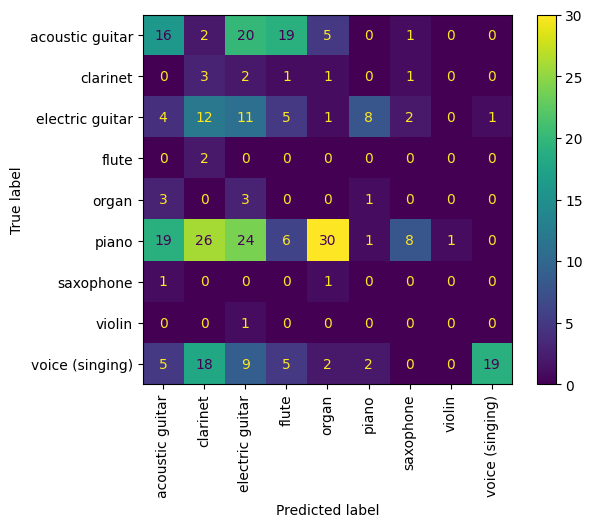

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Each row represents the true instrument, and each column shows what was predicted.
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

# Create a visualization object that labels the axes with instrument names.
disp = ConfusionMatrixDisplay(cm, display_labels=labels)

# Plot the confusion matrix:
disp.plot(xticks_rotation=90, cmap="viridis", values_format="d")
plt.show()

# Pretty Top-3 table

We print a compact table per clip showing:

* Filename
* True label
* Top-3 predicted labels with softmax confidence (so the numbers are easier to interpret)

In [18]:
from pathlib import Path as _P

# Convert raw similarity scores into probabilities using softmax.
# This makes the scores add up to 1 per clip, which helps interpret them as confidence levels.
confidence = torch.softmax(S, dim=1) # type: ignore

# Print a clean table header for the results.
# We’ll show: filename, true label, and the model’s top-3 guesses with confidence.
print(f"\n{'Filename':<42} | {'True label(s)':<28} | Top-3 predictions (confidence)")
print("-" * 110)

# Control how many examples to print (set to None to show everything).
MAX_PRINT = 50
rows_printed = 0

# Loop through each audio clip in the evaluation set.
for i, path in enumerate(paths_eval):

    # Get the top-3 most confident predictions for this clip.
    conf_values, ids = confidence[i].topk(3)

    # Format predictions like "piano (87.23%)" for each of the top-3.
    preds = [f"{labels[j]} ({conf_values[k].item() * 100:5.2f}%)"
             for k, j in enumerate(ids)]

    # Look up the ground-truth label.
    true = df_eval.loc[i, "label_single"]

    # Get just the file name (not the whole path), and shorten it if it’s too long.
    fname = _P(path).name
    fname = (fname[:40] + "…") if len(fname) > 41 else fname

    # Print one line: file name | true label | top-3 predictions
    print(f"{fname:<42} | {true:<28} | {'; '.join(preds)}")

    rows_printed += 1
    # Stop printing after MAX_PRINT rows (to avoid spamming the output).
    if MAX_PRINT and rows_printed >= MAX_PRINT:
        break


Filename                                   | True label(s)                | Top-3 predictions (confidence)
--------------------------------------------------------------------------------------------------------------
01 Don't Get Around Much Anymore-6.wav     | piano                        | clarinet (13.17%); acoustic guitar (12.51%); organ (11.81%)
01 Julian Bream - Albeniz- Mallorca, Opu…  | acoustic guitar              | flute (12.34%); organ (12.17%); electric guitar (12.10%)
01 - roads-15.wav                          | voice (singing)              | voice (singing) (18.17%); clarinet (17.01%); saxophone (13.40%)
01 Just One Of Those Things-16.wav         | piano                        | clarinet (16.75%); organ (15.76%); violin (12.99%)
1 - Hank's Other Bag-8.wav                 | piano                        | clarinet (17.54%); organ (16.44%); piano (12.32%)
01 - 999-1.wav                             | electric guitar              | electric guitar (17.00%); voice (singing) (

# Free-text retrieval (search across any dataframe)

This turns the notebook into a **search engine for sounds:**

* Embed **any** dataframe’s audio into vectors (reusing the same encoder).
* Turn a **free-text query** (e.g., “piano”, “clarinet solo”) into a text embedding. If ensembling is on, average multiple prompt phrasings.
* Compute similarity to find the **top-K** most relevant audio files.
* Return a tidy results table with rank, filename, true labels, and score. Optionally apply the same row-wise z-score used in evaluation to keep behavior consistent.

#### short summary

* Type a phrase, get matching audio clips
* Works on eval or any other subset
* Results include filenames, labels, and scores

In [19]:
# Helper: get a readable "true labels" string for any dataframe.
def _true_label_series(df_any: pd.DataFrame) -> pd.Series:
    """Return readable true labels (single or multi)."""
    if "label_single" in df_any.columns:
        return df_any["label_single"].fillna("—").astype(str)
    elif "labels_full" in df_any.columns:
        return df_any["labels_full"].apply(
            lambda L: ", ".join(L) if isinstance(L, list) and len(L) else "—"
        )
    else:
        return pd.Series(["—"] * len(df_any), index=df_any.index)

# Turn any dataframe with a 'filepath' column into audio embeddings.
# This lets us run retrieval on eval data or any other split in the same way.
def embed_df_audio(df_any: pd.DataFrame, batch_size=BATCH_SIZE) -> torch.Tensor:
    paths = df_any["filepath"].tolist()
    return encode_audio_in_batches(paths, batch_size=batch_size)  # [N, D] torch

@torch.no_grad()
def text_embed_phrase(phrase: str) -> torch.Tensor:
    """Encode a free-text query using ensemble prompts if enabled."""
    # Convert a user’s search phrase (e.g., "piano solo") into a text embedding.
    vecs = []
    if ENSEMBLE_PROMPTS:
        for temp in TEMPLATES:
            p = temp.format(phrase) if "{}" in temp else phrase
            v = text_embed(p)
            vecs.append(v / np.linalg.norm(v))
        v = np.mean(vecs, axis=0)
        v = v / np.linalg.norm(v)
    else:
        v = text_embed(phrase)

    # Return as a 2D tensor with batch dimension: shape [1, D]
    return torch.from_numpy(v).unsqueeze(0)  # [1, D]

def retrieve(df_any: pd.DataFrame, A_any: torch.Tensor, query: str, topk: int = 10) -> pd.DataFrame:
    """Return top-k ranked retrievals with filename, true label(s), and score."""
    # 1) Embed the free-text query (e.g., "piano", "clarinet solo").
    t = text_embed_phrase(query)                 # [1, D]

    # 2) Compute similarity between every audio embedding and the query embedding.
    sims = (A_any @ t.T).squeeze(1)              # [N]

    # 3) Optional: apply the same row-wise normalization used during evaluation.
    #    This keeps retrieval behavior consistent with how we computed metrics.
    if ROW_ZSCORE:
        sims = (sims - sims.mean()) / (sims.std().clamp_min(1e-6))

    # 4) Take the indices of the top-k most similar audio clips.
    idx = torch.argsort(sims, descending=True)[:topk].cpu().numpy().tolist()

    # 5) Build a small results table with rank, filename, true labels, and score.
    out = df_any.iloc[idx].copy()
    out["true_labels"] = _true_label_series(out)
    out["score"] = sims[idx].cpu().numpy()
    out.insert(0, "rank", np.arange(1, len(out) + 1))

    # Show only the basename (e.g., "file.wav") instead of the full path.
    out["filename"] = out["filepath"].apply(lambda p: Path(p).name)

    return out[["rank", "filename", "true_labels", "score"]]

In [20]:
df_eval['label_single'].unique()

array(['piano', 'acoustic guitar', 'voice (singing)', 'electric guitar',
       'organ', 'saxophone', 'clarinet', 'flute', 'violin'], dtype=object)

In [21]:
# Example: search for clips that sound like "piano" and show the top 10 matches.
hits = retrieve(df_eval, A, query="piano", topk=10)

In [22]:
def print_hits(hits_df: pd.DataFrame, max_rows: int = 10):
    # Print a neat, fixed-width table for quick inspection.
    print(f"\n{'Rank':<4} | {'Filename':<40} | {'True label(s)':<28} | Score")
    print("-" * 110)
    for _, r in hits_df.head(max_rows).iterrows():
        fname = r["filename"]
        # Truncate very long filenames so the table stays tidy.
        fname = (fname[:40] + "…") if len(fname) > 41 else fname
        print(f"{int(r['rank']):<4} | {fname:<40} | {r['true_labels']:<28} | {r['score']:.4f}")

# Print the retrieval results.
print_hits(hits)


Rank | Filename                                 | True label(s)                | Score
--------------------------------------------------------------------------------------------------------------
1    | 01. Caravan-11.wav                       | electric guitar              | 2.3989
2    | 01 the other side of the crash_over-15.w… | electric guitar              | 2.1962
3    | 01. Helmet - Pure-12.wav                 | electric guitar              | 2.1064
4    | 01. sensing-2.wav                        | piano                        | 2.0825
5    | 02 - synergistic perceptions-10.wav      | voice (singing)              | 1.9964
6    | 02 - synergistic perceptions-14.wav      | voice (singing)              | 1.9935
7    | 02 - synergistic perceptions-11.wav      | voice (singing)              | 1.9803
8    | 01. Helmet - Pure-15.wav                 | electric guitar              | 1.9587
9    | 01. The Chosen Hour-2.wav                | voice (singing)              | 1.9185
10   | 0